In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
import seaborn as sns
import os, time, re, random
from scipy import stats, io

import cobra
from cobra import Model, Reaction, Metabolite, flux_analysis

import warnings
warnings.filterwarnings('ignore')

In [2]:
# setup
pal4 = sns.color_palette("mako",4)
pal3 = sns.color_palette("mako",3)
pal2 = [sns.color_palette("mako",4)[3],sns.color_palette("mako",4)[0]]
pal22 = [sns.color_palette("mako",4)[0],sns.color_palette("mako",4)[3]]

folder = '../data/'

## functions
def flatten(t):
    return [item for sublist in t for item in sublist]

def fix_pvals(x):
    if x < 1e-16:
        x=1e-16
    return x

def powerfit(x, y, xnew):
    """line fitting on log-log scale"""
    k, m = np.polyfit(np.log(x), np.log(y), 1)
    return np.exp(m) * xnew**(k)


cpb
(14700, 37)
pvy
(19367, 117)
(14404, 10)
(19367, 10)
(20122, 19)


<Axes: >

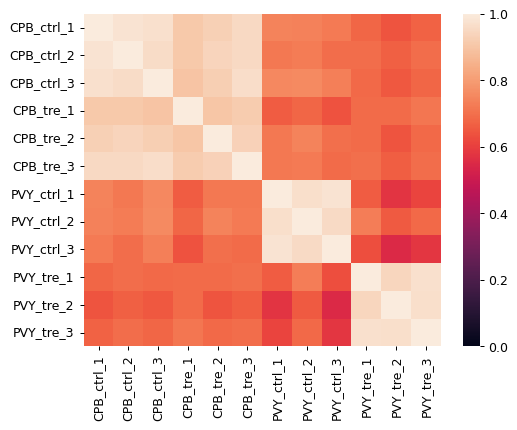

In [3]:
# load data
fs = ['cpb','pvy']
i=0
data_res = []
for f in fs:
    print(f)
    df = pd.read_csv(folder+fs[i]+'_tr_counts.tsv',sep='\t')
    print(df.shape)

    i+=1
    data_res.append(df)
    
data_res[1]['pgscID'].str.contains('PGSC').sum() # others are sotub

# subset
ctrl_cols = [
 ['B_1_con', 
 'B_2_con',
 'B_4_con',],
['Rywal_mock2_pool_STAR',
 'Rywal_mock3_pool_STAR',
 'Rywal_mock4_pool_STAR'],
]

tre_cols = [
['C_1_tre',
 'C_2_tre',
 'C_3_tre',],
['Rywal_wilga_2_poolA_STAR',
 'Rywal_wilga_3_poolA_STAR',
 'Rywal_wilga_5_poolA_STAR']
]

# construct
data = []
i=0
for i in range(len(ctrl_cols)): 
    col = ctrl_cols[i]+tre_cols[i]
    tmp = data_res[i].set_index('pgscID')[col]
    tmp['mean_exp'] = tmp.mean(axis=1).values
    tmp = tmp.reset_index() 
    tmp['exp'] = fs[i]
    tmp['type'] = 'control'
    tmp = tmp.drop_duplicates()
    print(tmp.shape)
    data.append(tmp)
    i+=1

# merge to data table
df_data = data[0].merge(data[1],on='pgscID',how='outer')
print(df_data.shape)

# correlation all vs all
cols = (ctrl_cols[0][:3]+tre_cols[0][:3])+(ctrl_cols[1]+tre_cols[1])
cols

# all columns combinations
df_corr = df_data.dropna()[cols].corr(method='spearman')

# rename columns
cols_rename = ['CPB_ctrl_1','CPB_ctrl_2','CPB_ctrl_3',
               'CPB_tre_1','CPB_tre_2','CPB_tre_3',
               'PVY_ctrl_1','PVY_ctrl_2','PVY_ctrl_3',
               'PVY_tre_1','PVY_tre_2','PVY_tre_3',
              ]

df_corr.columns = cols_rename
df_corr.index = cols_rename
    
# plot heatmap
mpl.rcParams['figure.dpi'] = 90
sns.heatmap(data=df_corr,vmin=0,vmax=1)


(13649, 19)


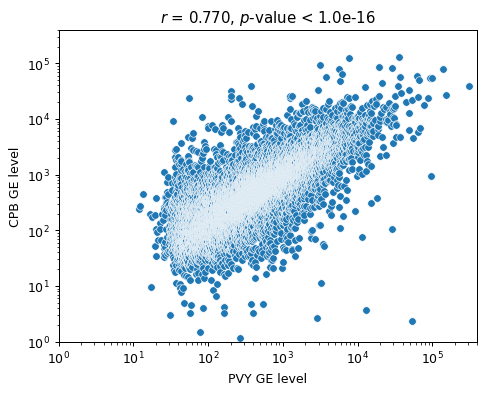

In [4]:
# correlation analysis

# inner join
tmp = (data[0]
 .merge(data[1],on='pgscID',how='inner')
 .sort_values(by=['mean_exp_x'])
)
print(tmp.shape)

mpl.rcParams['figure.dpi'] = 90
plt.figure(figsize=(6,4.5))
x = tmp.mean_exp_x.values
y = tmp.mean_exp_y.values

slope1, intercept1, rvalue, pvalue, stderr = stats.linregress(x,y)

sns.scatterplot(data=tmp,y='mean_exp_y',x='mean_exp_x')
plt.xscale('log')
plt.yscale('log')

rvalue,pvalue = stats.spearmanr(x,y)
plt.title('$r$ = '+str("%.3f" % rvalue)+ ', $p$-value < '+str("%.1e" % fix_pvals(pvalue)))
plt.ylabel(tmp.exp_x.loc[0].upper()+' GE level')
plt.xlabel(tmp.exp_y.loc[0].upper()+' GE level')

plt.xlim(1e0,4e5)
plt.ylim(1e0,4e5)

plt.show()


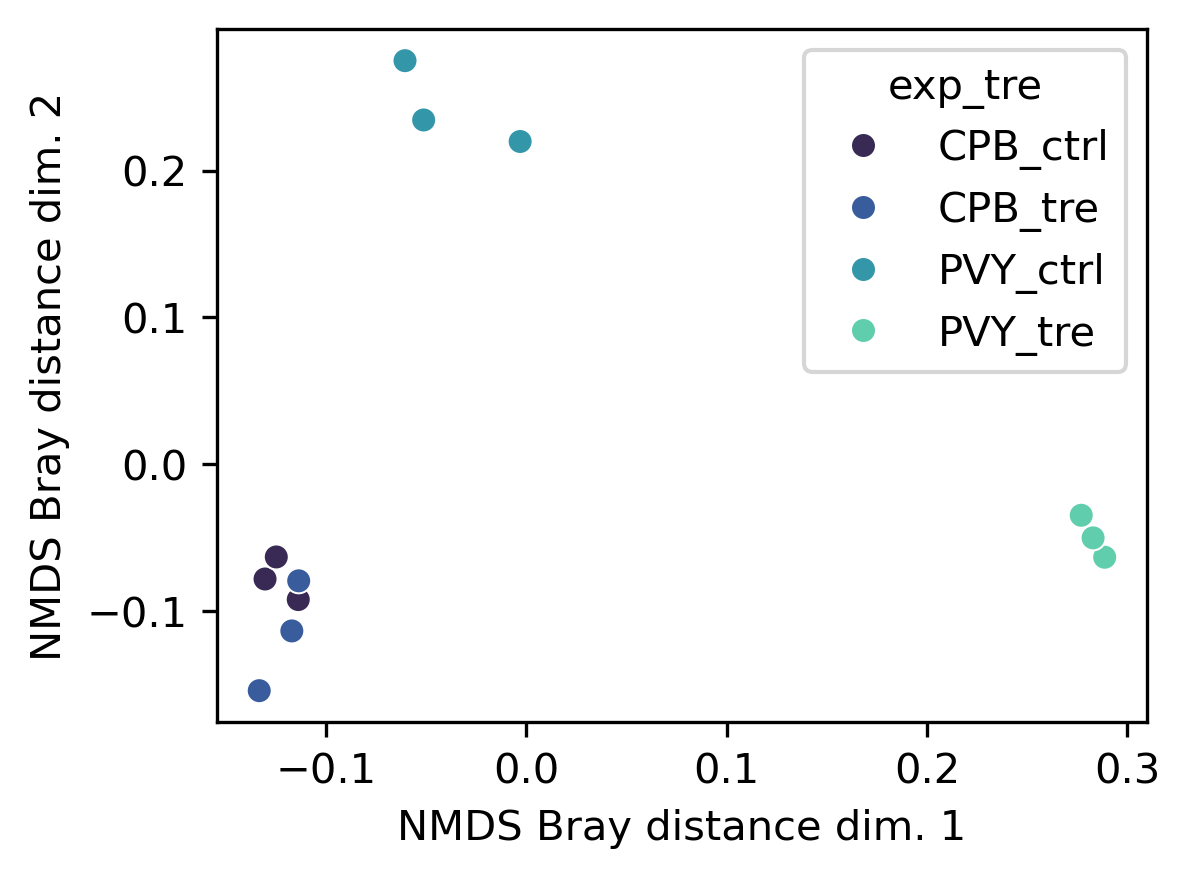

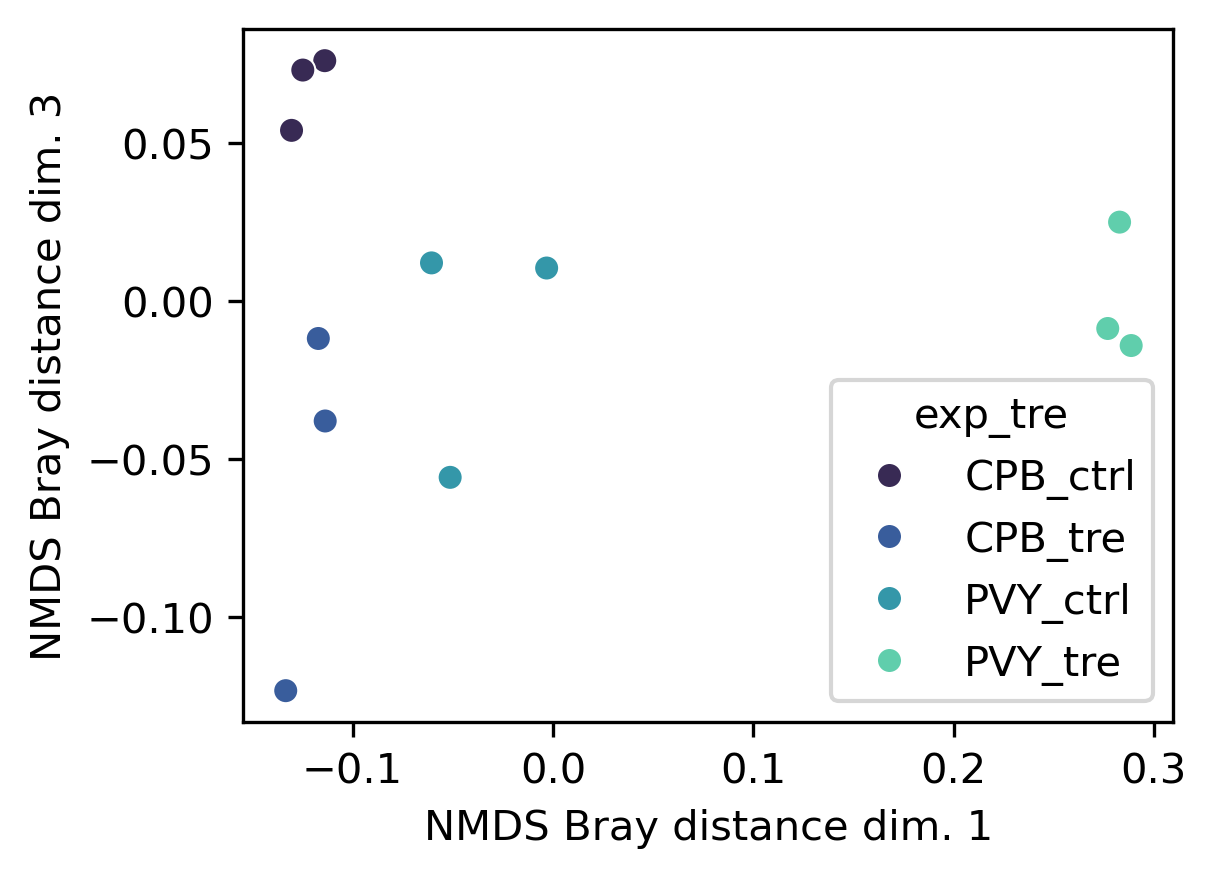

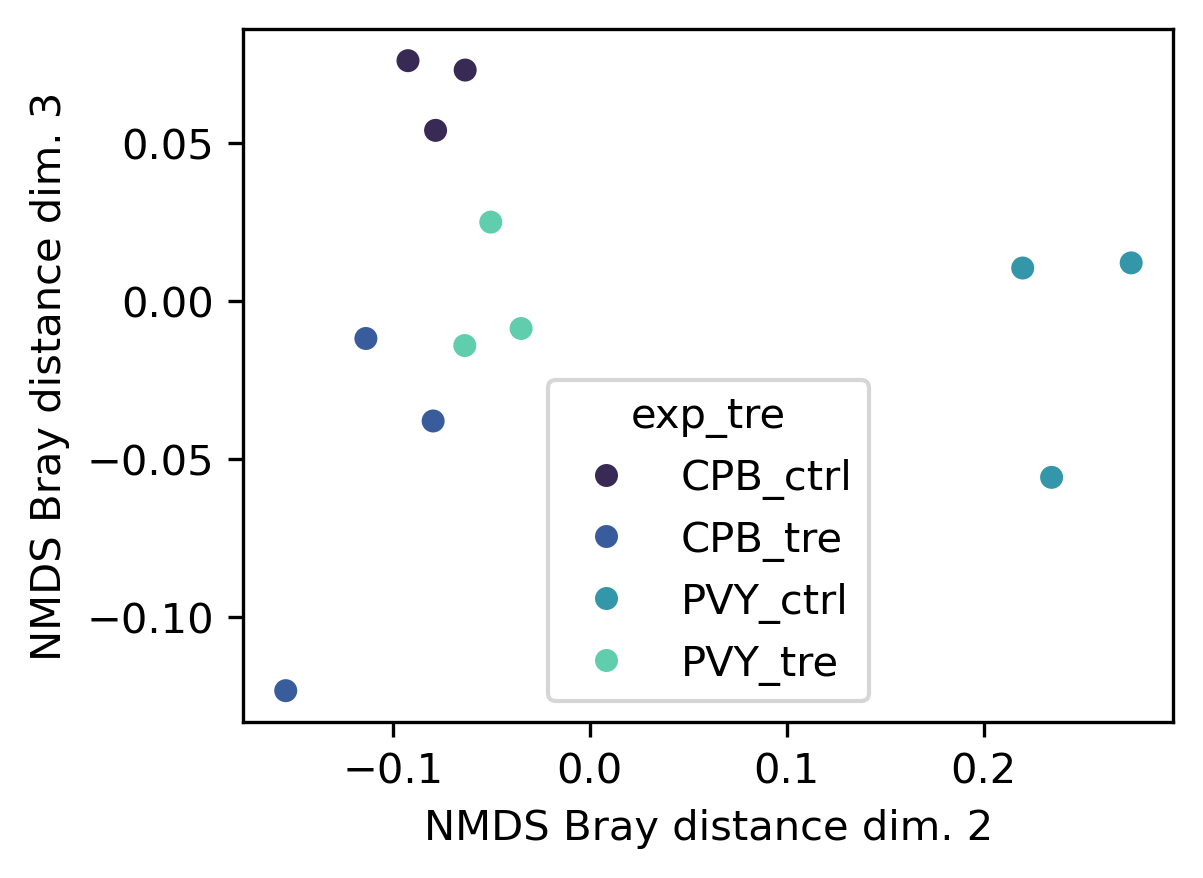

In [5]:
# supplement NDMS
df_plot = pd.read_csv(folder+'05_PCoA-on-distance-bray__raw_k-3_points.txt',sep='\t')
cols_rename = ['CPB_ctrl_1','CPB_ctrl_2','CPB_ctrl_3',
               'CPB_tre_1','CPB_tre_2','CPB_tre_3',
               'PVY_ctrl_1','PVY_ctrl_2','PVY_ctrl_3',
               'PVY_tre_1','PVY_tre_2','PVY_tre_3',
              ]
df_plot['tmp'] = cols_rename
df_plot['exp_tre'] =  df_plot.tmp.apply(lambda x: '_'.join(x.split('_')[:2]))

# all combinations
mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(4,3))
sns.scatterplot(data=df_plot,
              x='V1',y='V2',
             hue='exp_tre',palette=pal4)
plt.xlabel('NMDS Bray distance dim. 1')
plt.ylabel('NMDS Bray distance dim. 2')
plt.show()

plt.figure(figsize=(4,3))
sns.scatterplot(data=df_plot,
              x='V1',y='V3',
             hue='exp_tre',palette=pal4)
plt.xlabel('NMDS Bray distance dim. 1')
plt.ylabel('NMDS Bray distance dim. 3')
plt.show()

plt.figure(figsize=(4,3))
sns.scatterplot(data=df_plot,
              x='V2',y='V3',
             hue='exp_tre',palette=pal4)
plt.xlabel('NMDS Bray distance dim. 2')
plt.ylabel('NMDS Bray distance dim. 3')
plt.show()


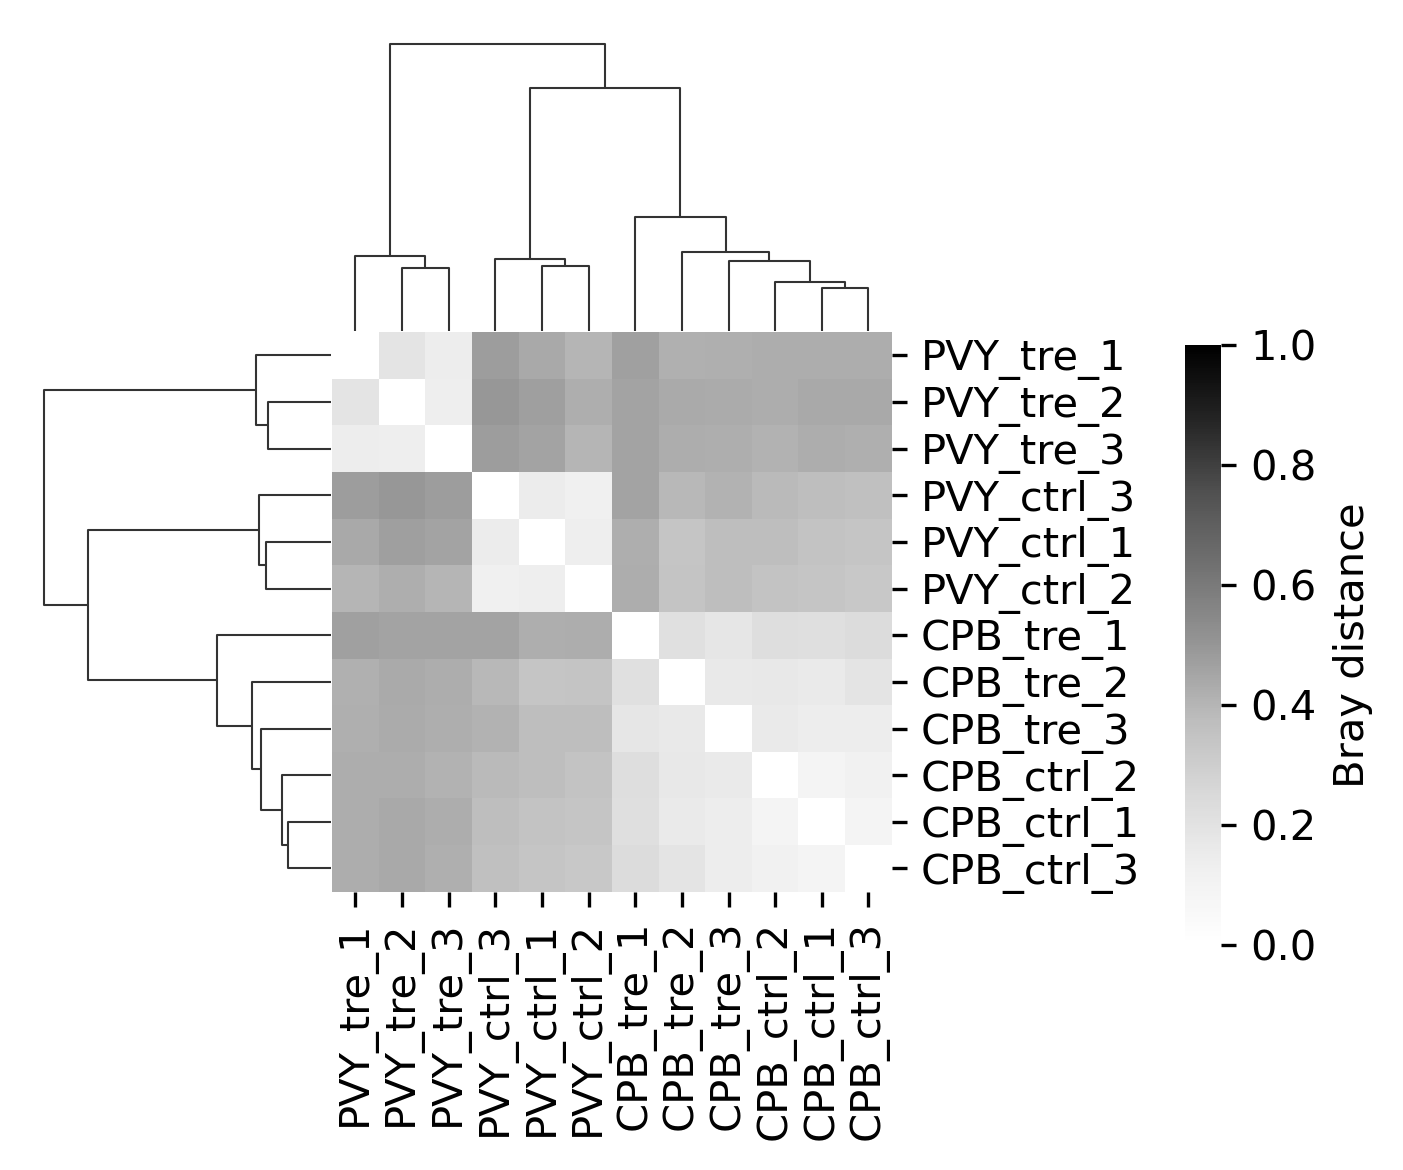

In [6]:
# heatmap with dendrogram
df_plot = pd.read_csv(folder+'05_distance-heatmap-bray__raw_k-3.txt',sep='\t')
cols_rename = ['CPB_ctrl_1','CPB_ctrl_2','CPB_ctrl_3',
               'CPB_tre_1','CPB_tre_2','CPB_tre_3',
               'PVY_ctrl_1','PVY_ctrl_2','PVY_ctrl_3',
               'PVY_tre_1','PVY_tre_2','PVY_tre_3',
              ]
df_plot.columns= cols_rename
df_plot.index = cols_rename
df_plot

sns.clustermap(df_plot,
               cmap='Greys',
               dendrogram_ratio=0.35,
               figsize=(4,4),
               vmin=0,vmax=1,
               cbar_pos=(1, 0.2, .03, 0.5),
               cbar_kws={'label': 'Bray distance'}
              )


(325, 10)
(21, 3)
(48922, 2)
(34, 3)


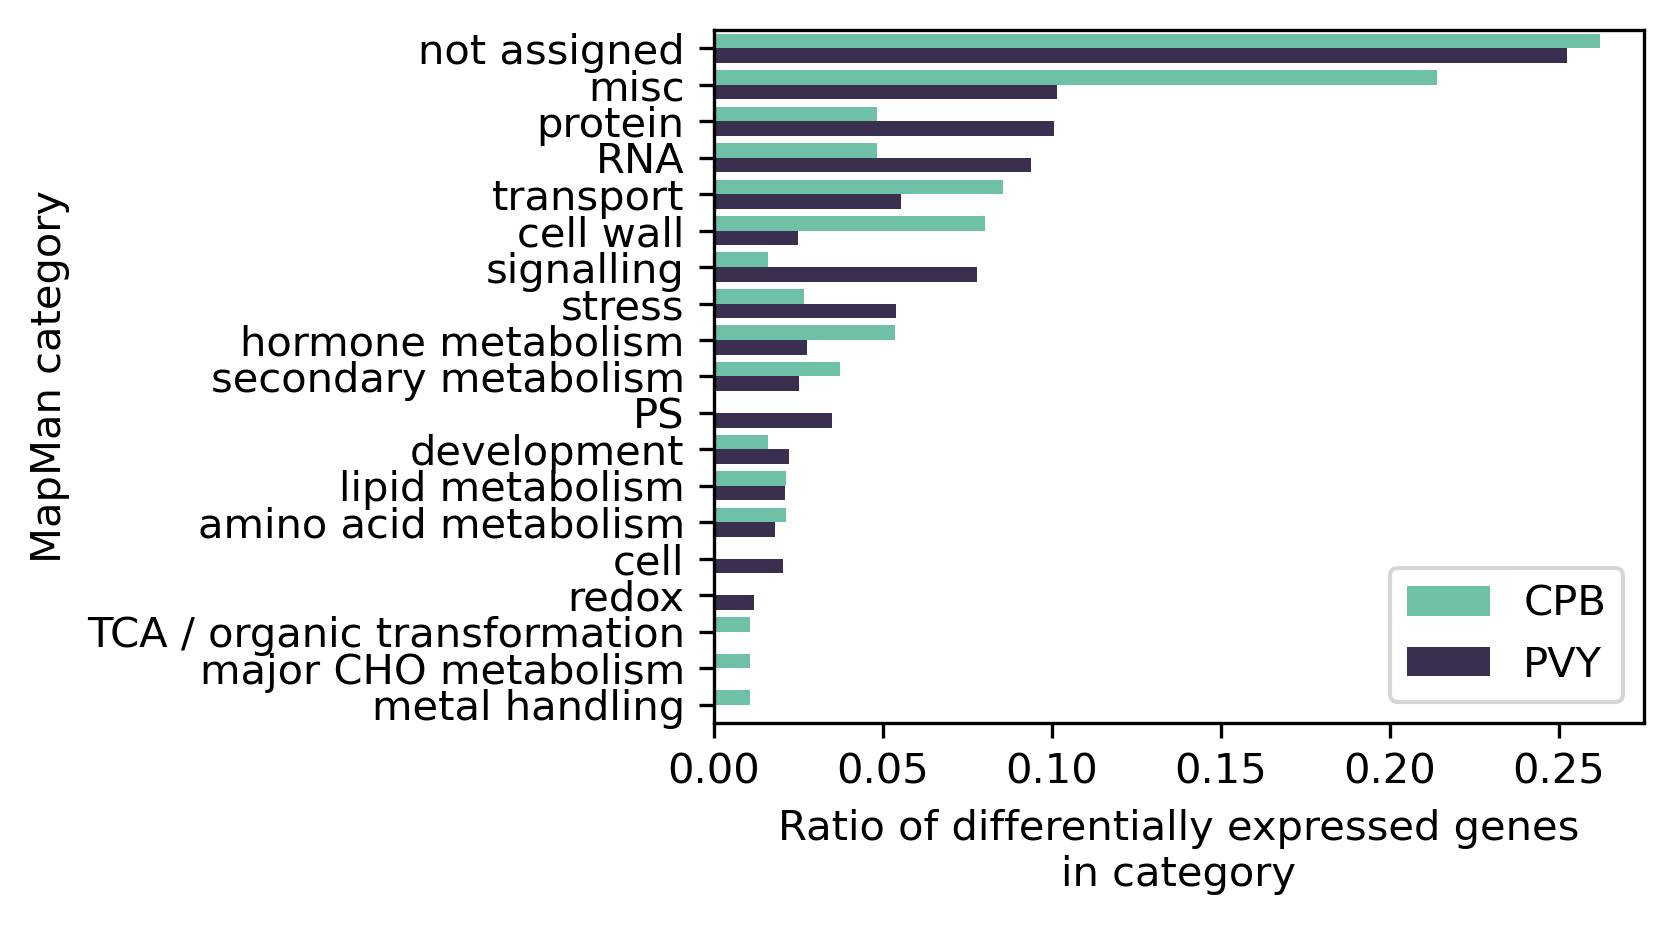

In [7]:
# load DEG and enrichment results

# load
cpb_deg = pd.read_excel(folder+'CPB_Deseq2_DEGs-and-GMM.xlsx')
print(cpb_deg.query('padj<0.05').shape)

cpb_deg['MapManBINs']= cpb_deg['MapManBINs'].fillna('')
cpb_deg['group'] = cpb_deg.MapManBINs.apply(lambda x: ' '.join(x.split('|')[-1].split(' ')[1:]))
cpb_deg = cpb_deg.query('log2FoldChange>=2 or log2FoldChange<=-2')
cpb_deg = cpb_deg['group'].value_counts().divide(cpb_deg.shape[0]).rename('counts').reset_index()
cpb_deg['exp'] = 'CPB'
print(cpb_deg.shape)

#
pvy_deg = (pd.read_excel(folder+'Supplementary Table RNASeq_results.xlsx')
           [['Unnamed: 3', 'Unnamed: 71']]
           .iloc[4:]
          )
pvy_deg.columns=['MapManBINs','log2FoldChange']
pvy_deg['log2FoldChange'] = pvy_deg.log2FoldChange.fillna(0)
print(pvy_deg.shape)

pvy_deg['MapManBINs']= pvy_deg['MapManBINs'].fillna('')
pvy_deg['group'] = pvy_deg.MapManBINs.apply(lambda x: x.split('_')[1].split('.')[0])
pvy_deg = pvy_deg.query('log2FoldChange>=2 or log2FoldChange<=-2')
pvy_deg = pvy_deg['group'].value_counts().divide(pvy_deg.shape[0]).rename('counts').reset_index()
pvy_deg['exp'] = 'PVY'
print(pvy_deg.shape)

# plot
df_plot = (pd.concat([cpb_deg,pvy_deg])
           .query('counts>0.01')
           .sort_values(by='counts',ascending=False)
           .query('group!=""')
          )
df_plot

mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(4,3))
sns.barplot(data=df_plot,
           x='counts',y='group',hue='exp',
            palette=pal2
           )
plt.xlabel('Ratio of differentially expressed genes\nin category')
plt.ylabel('MapMan category')
plt.legend(loc='lower right')
plt.show()


(73, 6)
(76, 11)


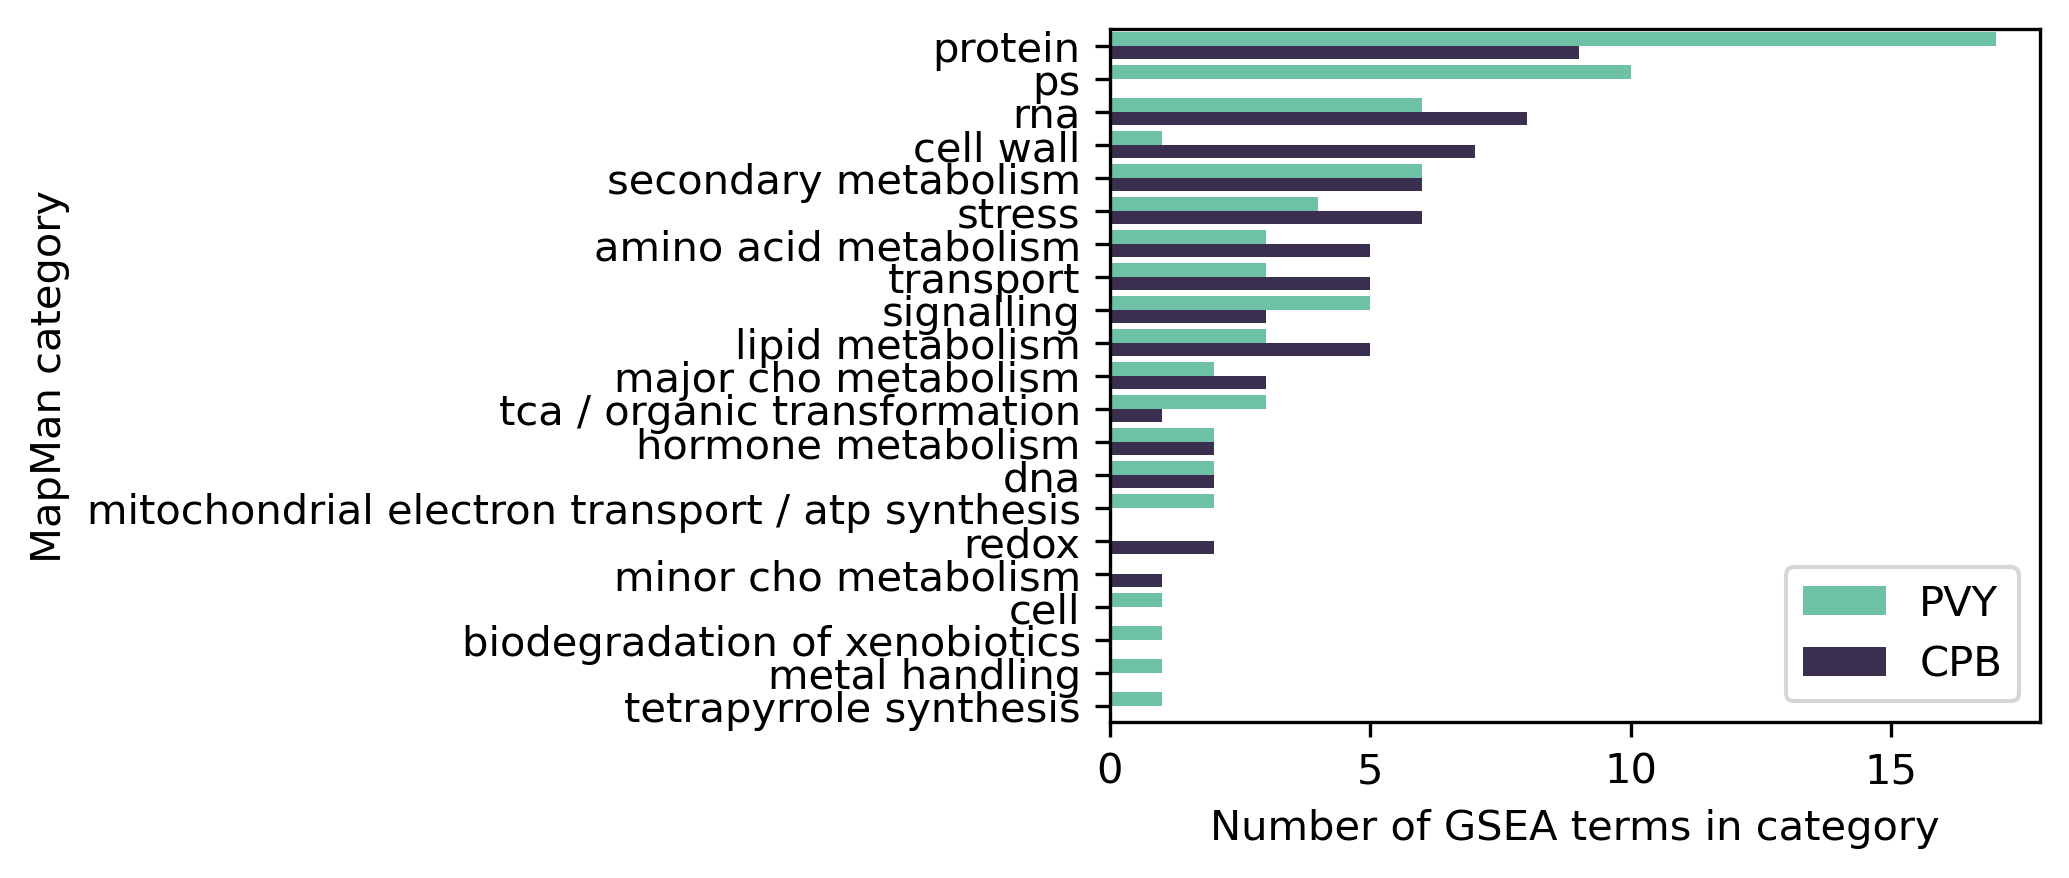

In [8]:
# load and plot mapman enrichment gsea
import re

# laod
cpb_gsea = pd.read_excel(folder+'CPB_GSEA-MapMan_few-cols.xlsx')
cpb_gsea = cpb_gsea[cpb_gsea['FDR q-val']<0.05]
print(cpb_gsea.shape)
cpb_gsea.NAME.tolist()
cpb_gsea['group'] = (cpb_gsea.NAME.apply(lambda x: re.sub("\d+", " ", x)
                                         .replace('. ','')
                                         .split('.')[0]
                                         .strip('  ')
                                         .lower() # lowercase
                                        )
                    )
cpb_gsea['exp'] = 'CPB'

pvy_gsea = pd.read_excel(folder+'PVY-gffMerged_GSEA-MapMan_few-cols.xlsx',                     
                        skiprows=0)
pvy_gsea = pvy_gsea[pvy_gsea['FDR q-val|AvsMock']<0.05]
print(pvy_gsea.shape)
pvy_gsea.NAME.tolist()
pvy_gsea['group'] = (pvy_gsea.NAME.apply(lambda x: re.sub("\d+", " ", x)
                                         .replace('. ','')
                                         .split('.')[0]
                                         .strip('  ')
                                         .lower()
                                        )
                    )
pvy_gsea['exp'] = 'PVY'

# plot
df_plot = pd.concat([cpb_gsea,pvy_gsea])
df_plot = (df_plot.groupby(['exp','group'])
           .NAME.nunique()
           .rename('counts')
           .reset_index()
           .sort_values(by='counts',ascending=False)
          )
df_plot

drop = ['misc','not assigned']

mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(4,3))
sns.barplot(data=df_plot.query('~group.isin(@drop)'),
           x='counts',y='group',hue='exp',
            palette=pal2
           )
plt.xlabel('Number of GSEA terms in category')
plt.ylabel('MapMan category')
plt.legend(loc='lower right')
plt.show()
